In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
ling = pd.read_csv('ling_preprocessed.csv')
ling

,Unnamed: 0,preprocessed_data,label
0,0,"['job', 'posting', 'appleiss', 'research', 'ce...",0
1,1,"['nan', 'lang', 'classification', 'grimes', 'j...",0
2,2,"['query', 'letter', 'frequencies', 'text', 'id...",0
3,3,"['risk', 'colleague', 'researching', 'differin...",0
4,4,"['request', 'book', 'information', 'earlier', ...",0
...,...,...,...
2854,2854,"['win', 'usd', 'cruise', 'raquel', 'casino', '...",1
2855,2855,"['asked', 'join', 'kiddin', 'list', 'owner', '...",1
2856,2856,"['anglicization', 'composers', 'names', 'judgi...",0
2857,2857,"['comparative', 'method', 'n', 'ary', 'compari...",0


0    2401
1     458
Name: label, dtype: int64


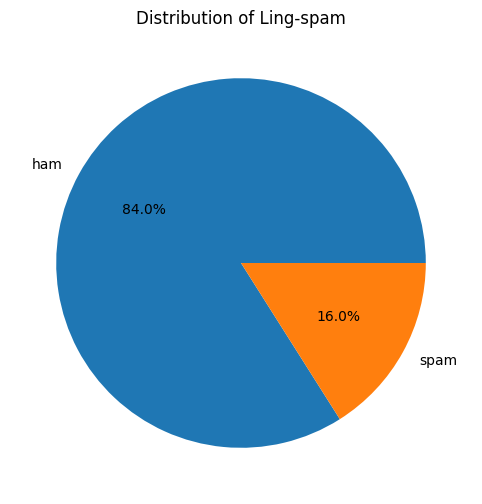

In [3]:
label_counts = ling["label"].value_counts()

print(label_counts)

plt.figure(figsize=(8, 6))
plt.pie(label_counts.values, labels=["ham", "spam"], autopct='%1.1f%%')
plt.title('Distribution of Ling-spam')
plt.savefig(os.path.join("./figs", "ling_pie_chart.jpg"))
plt.show()

In [4]:
import sys

sys.path.append("../Handlers")

import preprocessing

[nltk_data] Downloading package punkt to E:/nltk...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
ling_X, ling_y = ling["preprocessed_data"], ling["label"]

import ast

ling_X = ling_X.apply(lambda x: ast.literal_eval(x))

In [6]:
from traintest import ClassificationModel2, add_to_json_array

metric_results = []

## Stemming + CountVectorizer

In [7]:
ling_X_stemming = ling_X.apply(preprocessing.stemming)

In [8]:
ling_X_stemming_countvec = preprocessing.vectorizing(ling_X_stemming, "countvectorizer")

Val size:  (286, 10570)
Threading avaiable
Begin KNeighborsClassifier
Skipping epochs training due to longevity.
Begin LinearSVC
Skipping epochs training due to longevity.
Begin MultinomialNB
Skipping epochs training due to longevity.
Begin BernoulliNB
Skipping epochs training due to longevity.
MultinomialNB classification report
range(1, 11)
10
10
BernoulliNB classification report
range(1, 11)
10
10
LinearSVC classification report
range(1, 11)
10
10
Begin RandomForestClassifier
Begin DecisionTreeClassifier
Begin AdaBoostClassifier
Skipping epochs training due to longevity.
KNeighborsClassifier classification report
range(1, 11)
10
10
DecisionTreeClassifier classification report
range(1, 11)
10
10
Begin LogisticRegression
Begin SGDClassifier
Begin Perceptron
Skipping epochs training due to longevity.
Perceptron classification report
range(1, 11)
10
10
Begin PassiveAggressiveClassifier
Skipping epochs training due to longevity.
PassiveAggressiveClassifier classification report
range(1, 

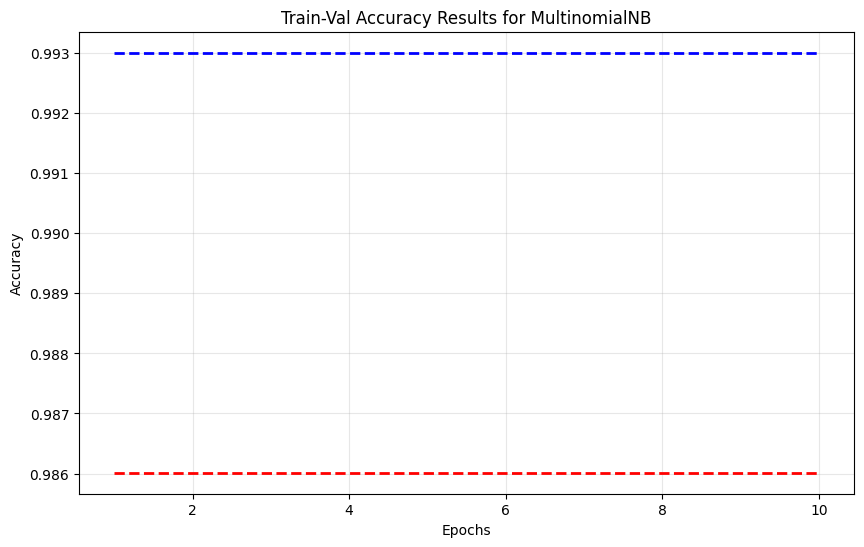

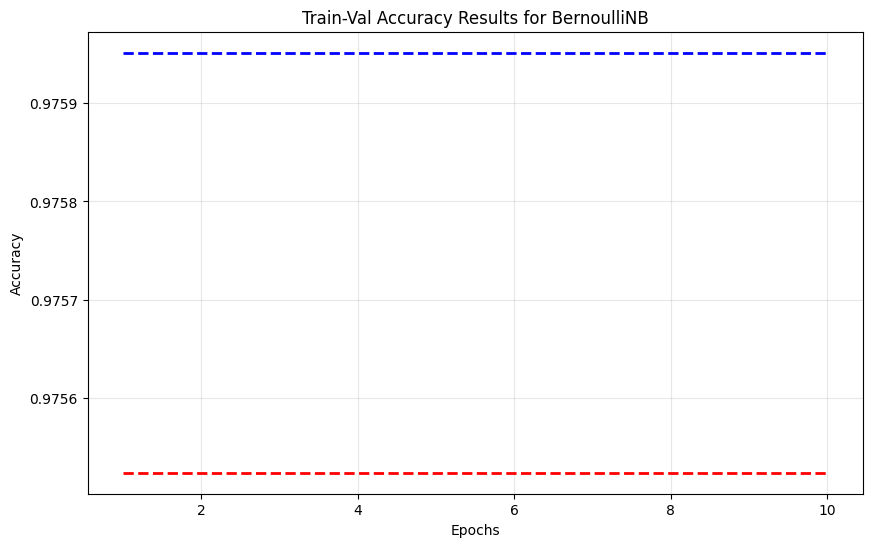

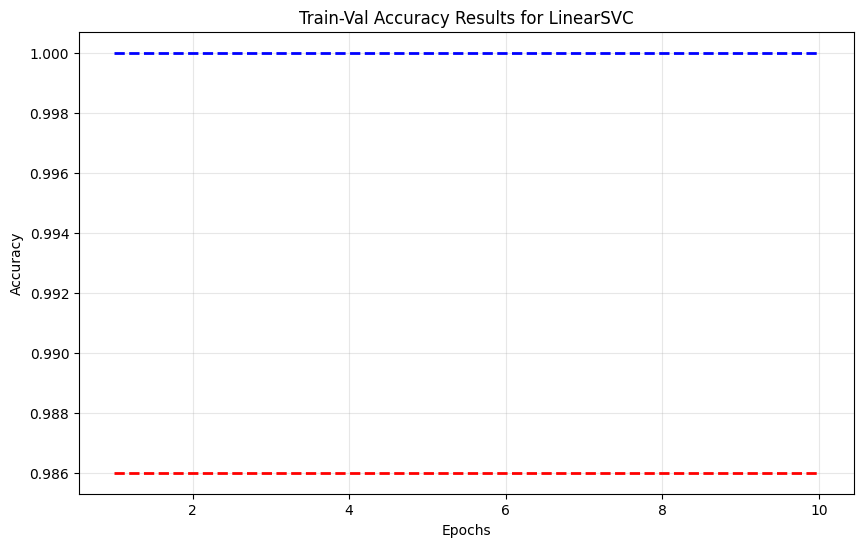

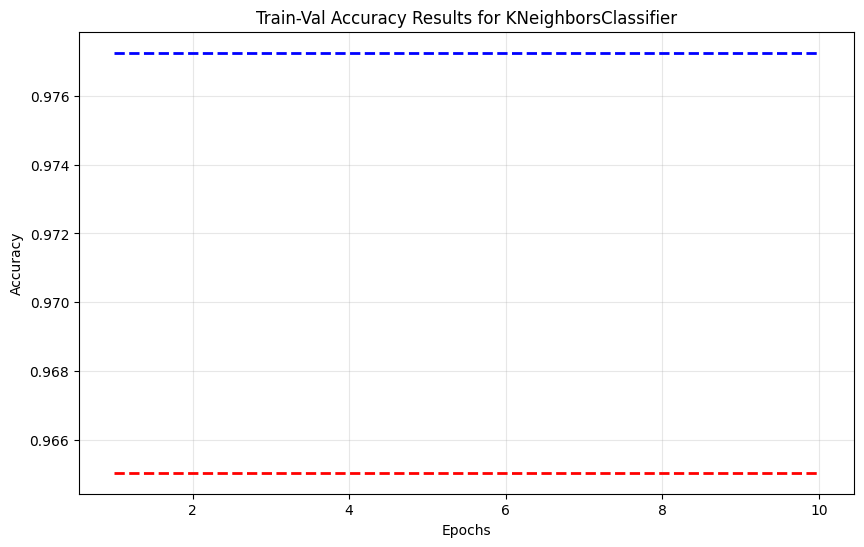

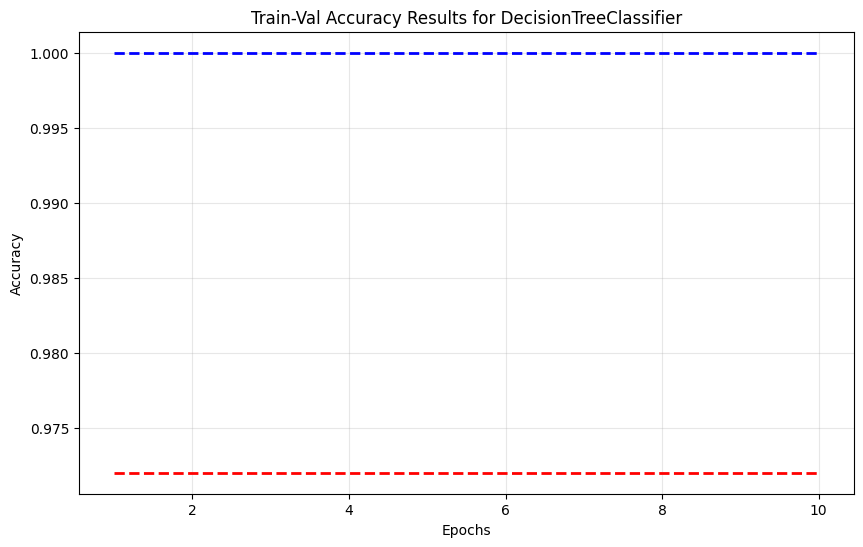

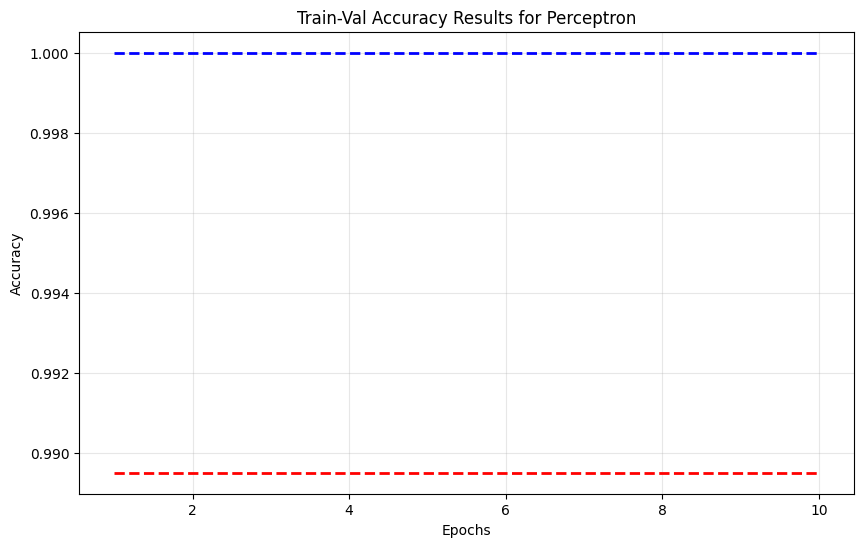

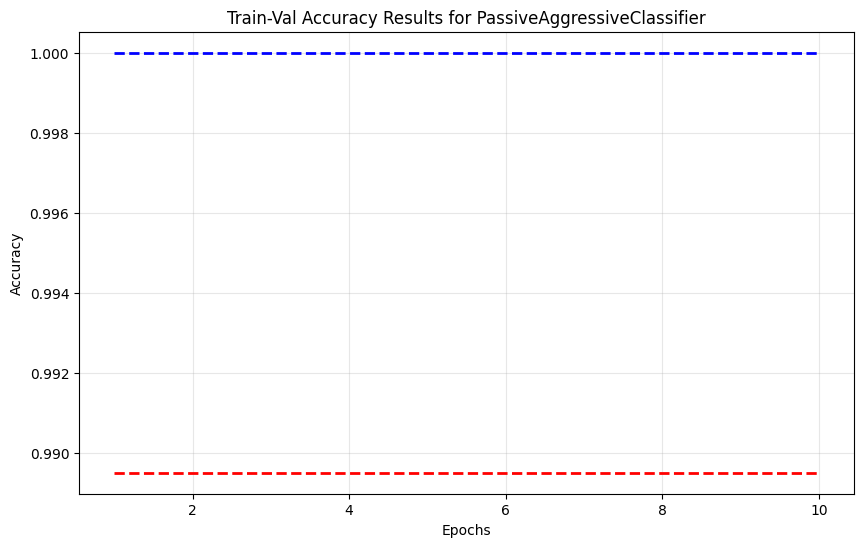

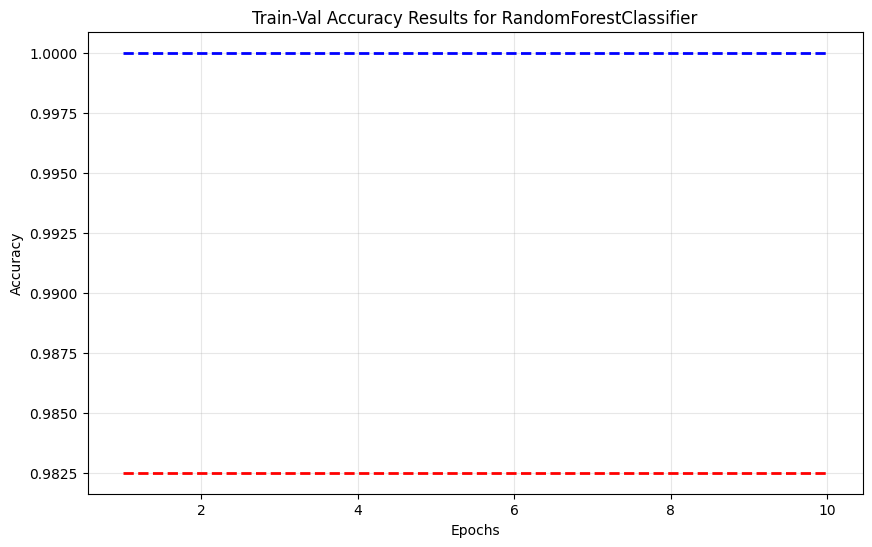

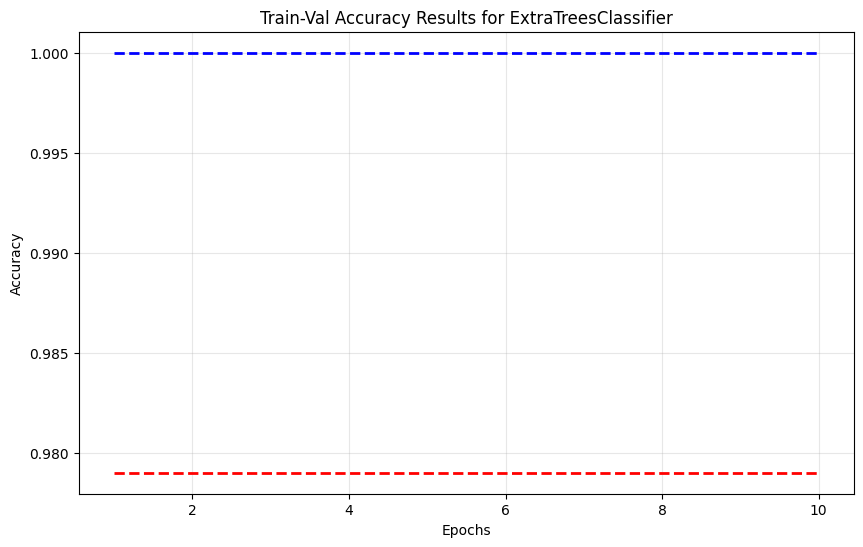

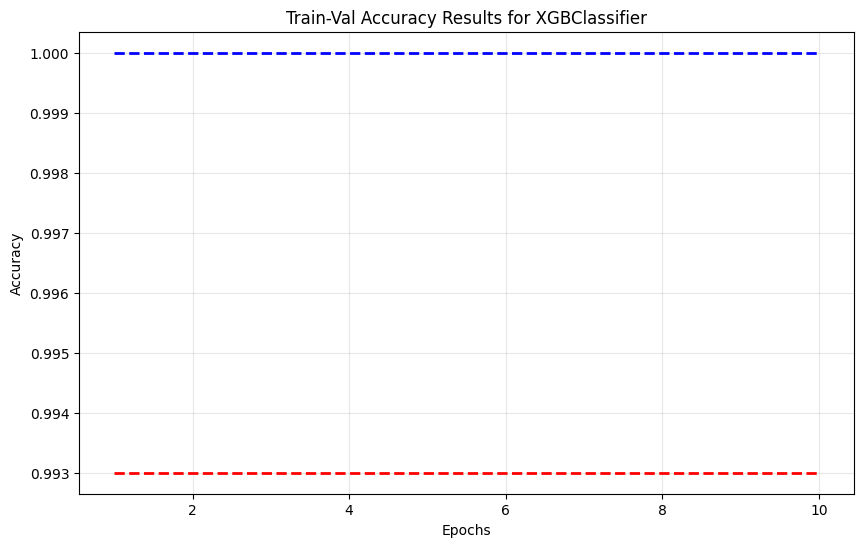

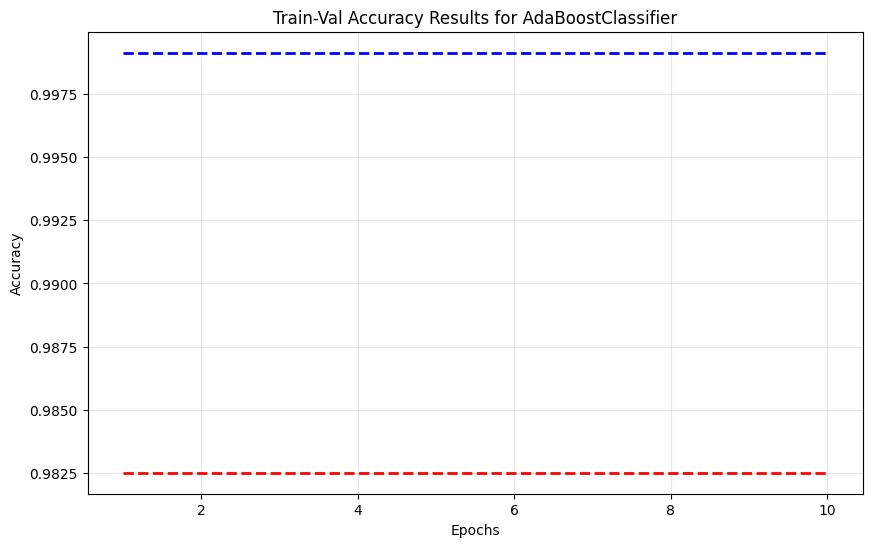

In [9]:
clsml2 = ClassificationModel2(ling_X_stemming_countvec, ling_y, "ling_stemmed_countvec")
clsml2.split()

m_r = clsml2.train_and_evaluate_models(
    valid_size=0.1,
    max_workers=4,
    nomlp=True,
    threading=True,
    save_plot=True
)

metric_results.extend(m_r)

del ling_X_stemming_countvec, m_r

## Stemming + TF-IDF

Val size:  (286, 10570)
Threading avaiable
Begin KNeighborsClassifier
Skipping epochs training due to longevity.
Begin LinearSVC
Skipping epochs training due to longevity.
Begin MultinomialNB
Skipping epochs training due to longevity.
Begin BernoulliNB
Skipping epochs training due to longevity.
MultinomialNB classification report
range(1, 11)
10
10
LinearSVC classification report
range(1, 11)
10
10
BernoulliNB classification report
range(1, 11)
10
10
Begin RandomForestClassifier
Begin DecisionTreeClassifier
Begin AdaBoostClassifier
Skipping epochs training due to longevity.
DecisionTreeClassifier classification report
range(1, 11)
10
10
Begin LogisticRegression
RandomForestClassifier classification report
range(1, 11)
10
10
Begin SGDClassifier
Begin Perceptron
Skipping epochs training due to longevity.
Perceptron classification report
range(1, 11)
10
10
Begin PassiveAggressiveClassifier
Skipping epochs training due to longevity.
PassiveAggressiveClassifier classification report
range(1

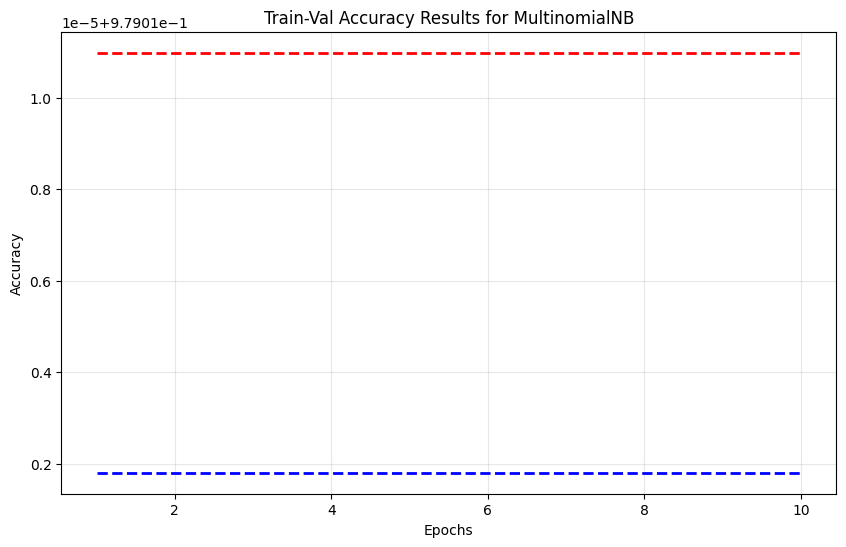

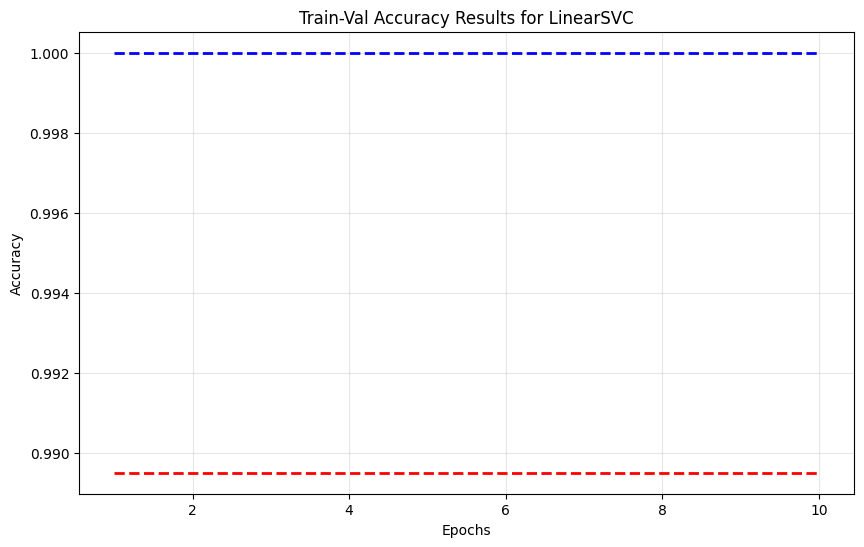

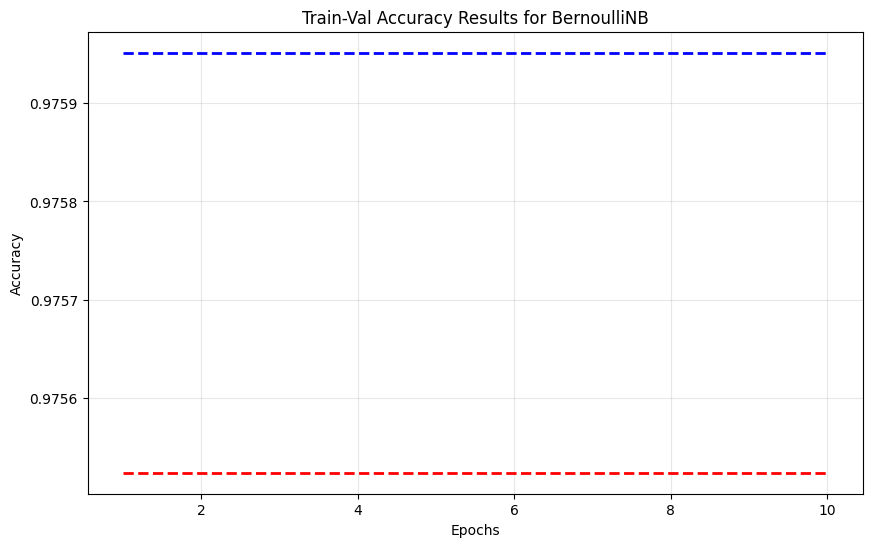

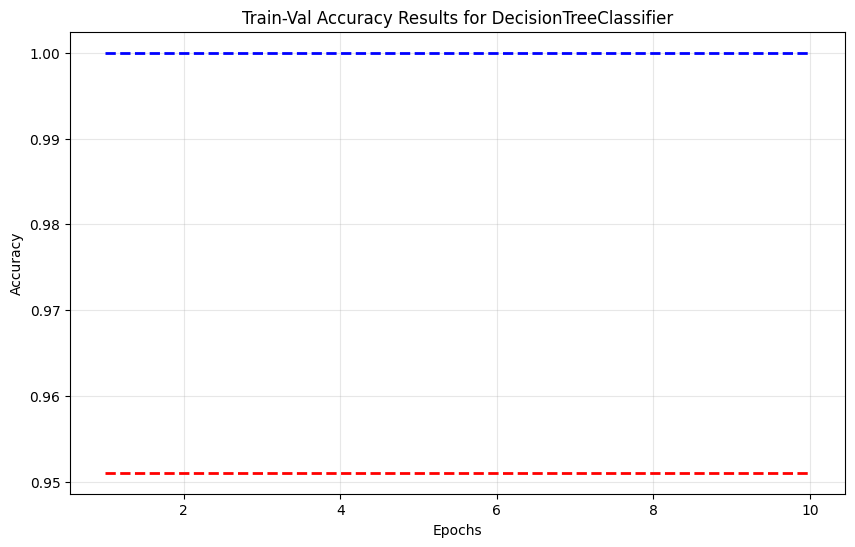

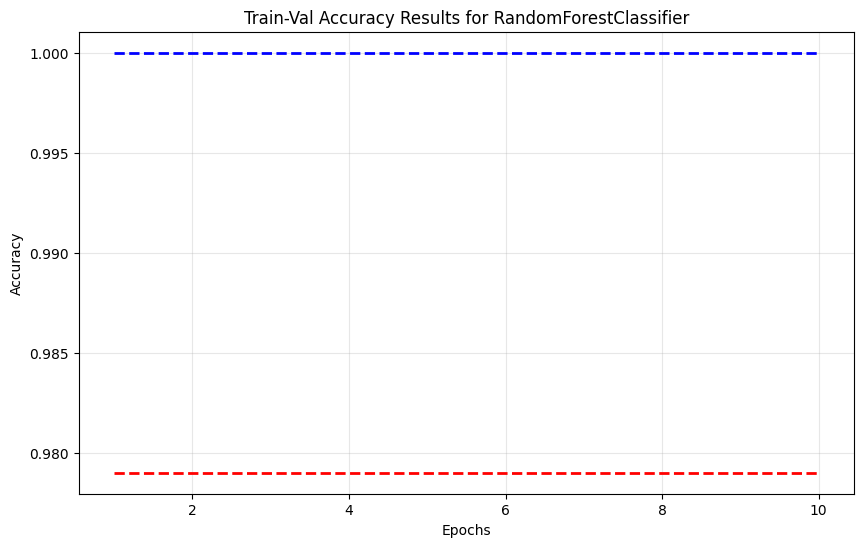

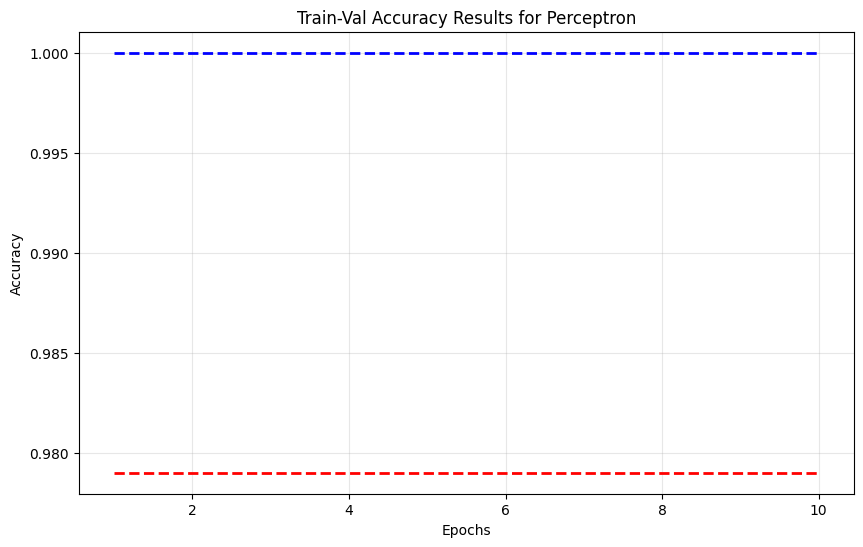

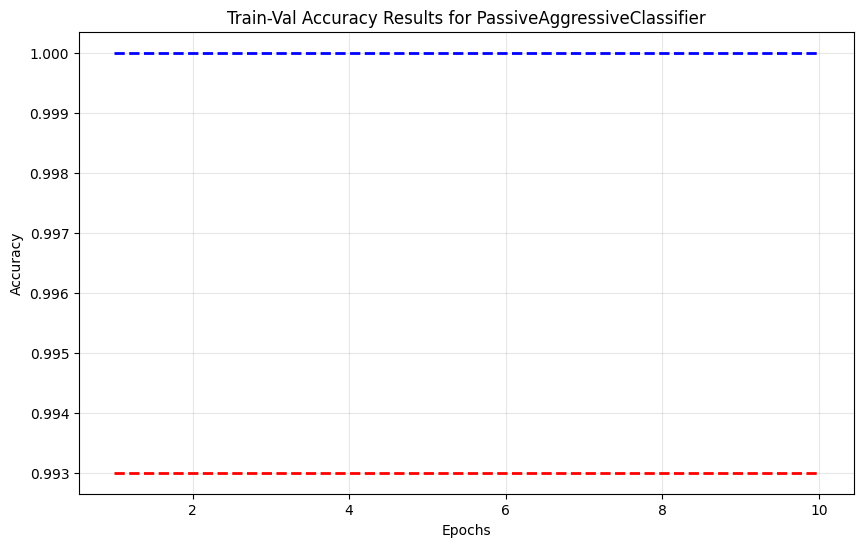

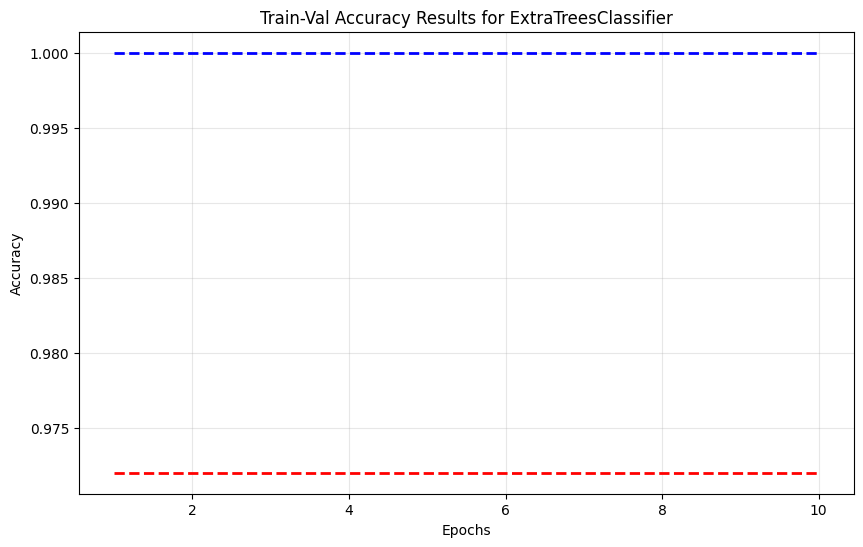

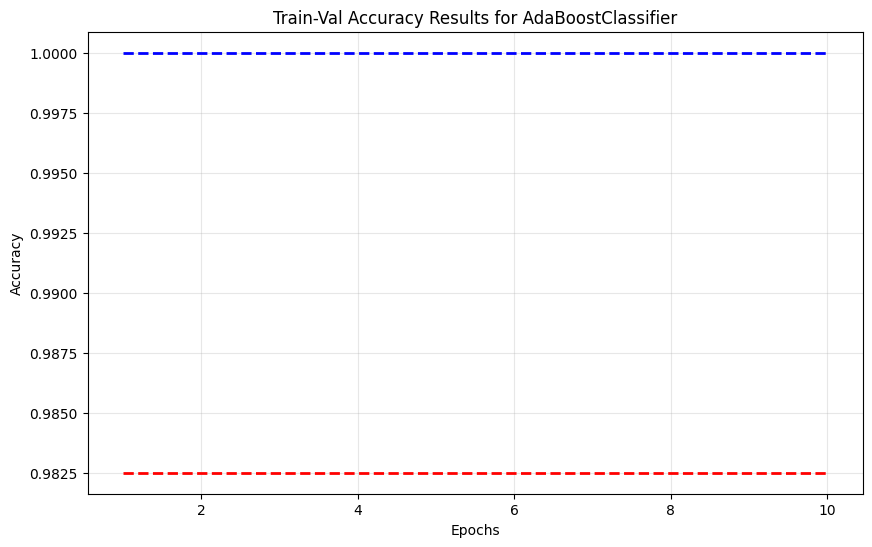

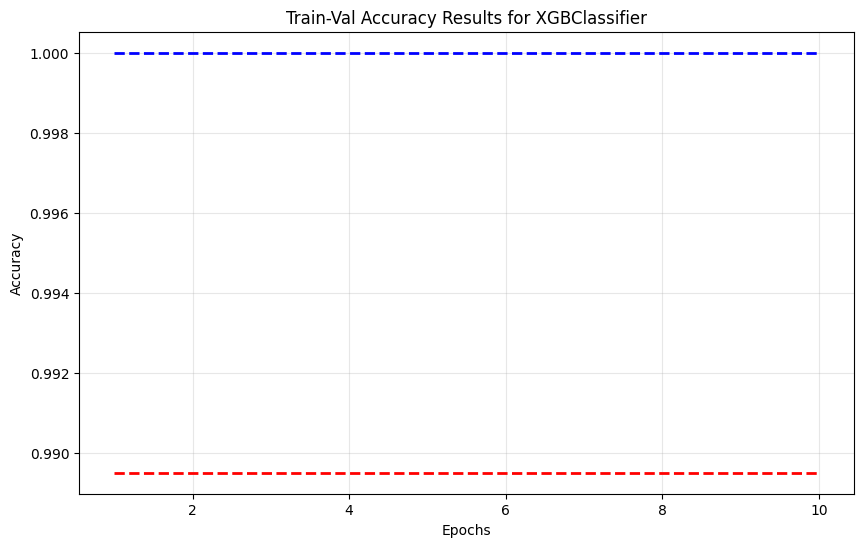

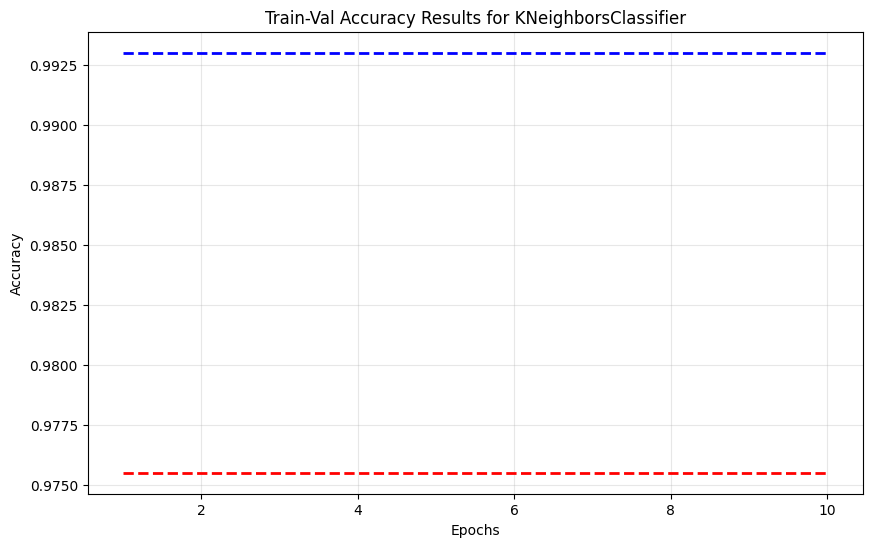

In [10]:
ling_X_stemming_tfidf = preprocessing.vectorizing(ling_X_stemming, "tfidf")

clsml2 = ClassificationModel2(ling_X_stemming_tfidf, ling_y, "spam_assassin_stemmed_tfidf")
clsml2.split()

m_r = clsml2.train_and_evaluate_models(
    valid_size=0.1,
    max_workers=4,
    nomlp=True,
    threading=True,
    save_plot=True
)

metric_results.extend(m_r)

del m_r
del ling_X_stemming_tfidf
del ling_X_stemming

## Lemmatizing + CountVectorizer

In [11]:
ling_X_lemmatizing = ling_X.apply(preprocessing.lemmatizing)

Val size:  (286, 12802)
Threading avaiable
Begin KNeighborsClassifier
Skipping epochs training due to longevity.
Begin LinearSVC
Skipping epochs training due to longevity.
Begin MultinomialNB
Skipping epochs training due to longevity.
Begin BernoulliNB
Skipping epochs training due to longevity.
MultinomialNB classification report
range(1, 11)
10
10
BernoulliNB classification report
range(1, 11)
10
10
LinearSVC classification report
range(1, 11)
10
10
Begin RandomForestClassifier
Begin DecisionTreeClassifier
Begin AdaBoostClassifier
Skipping epochs training due to longevity.
KNeighborsClassifier classification report
range(1, 11)
10
10
Begin LogisticRegression
DecisionTreeClassifier classification report
range(1, 11)
10
10
Begin SGDClassifier
Begin Perceptron
Skipping epochs training due to longevity.
Perceptron classification report
range(1, 11)
10
10
Begin PassiveAggressiveClassifier
Skipping epochs training due to longevity.
PassiveAggressiveClassifier classification report
range(1, 

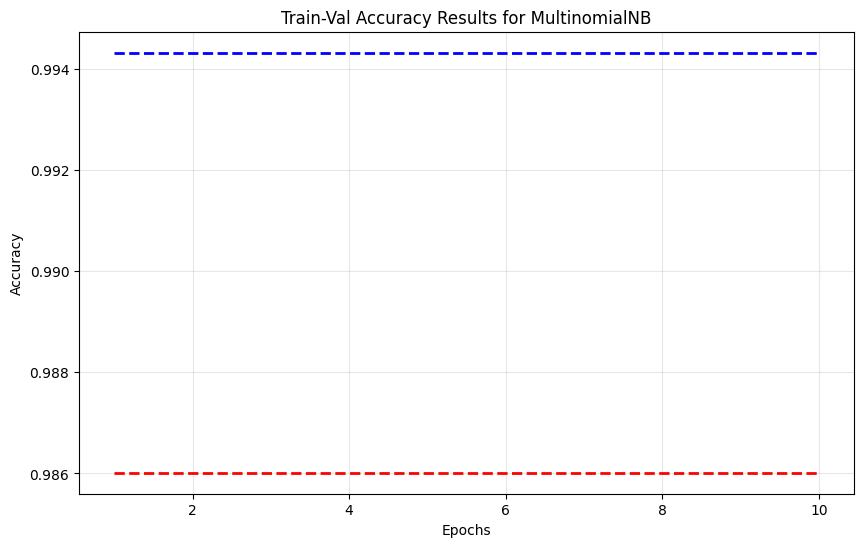

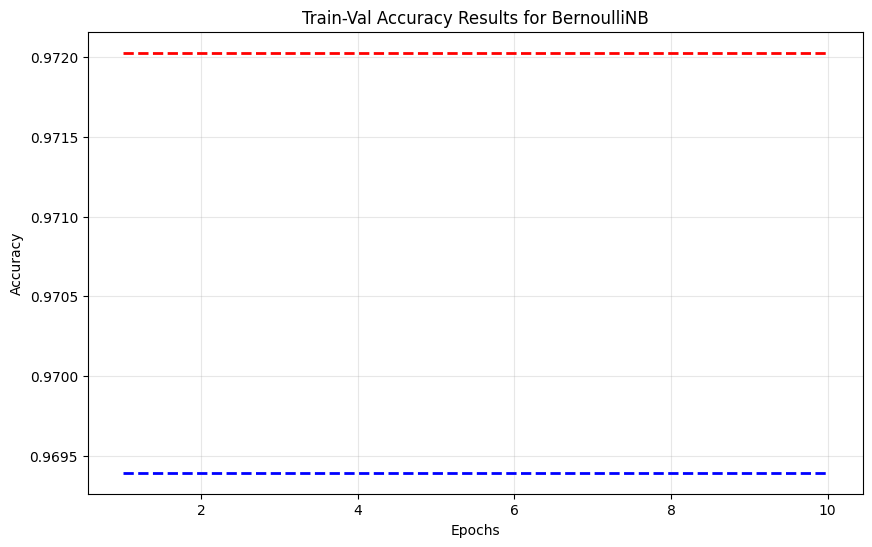

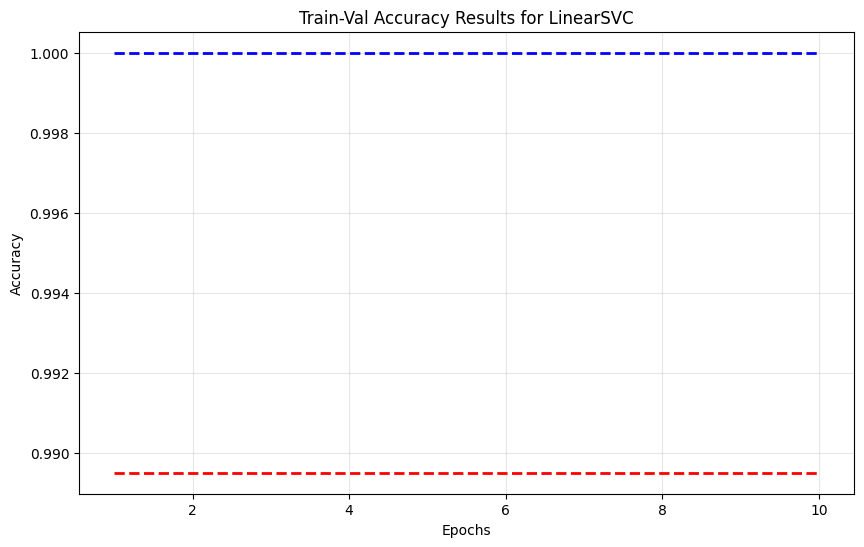

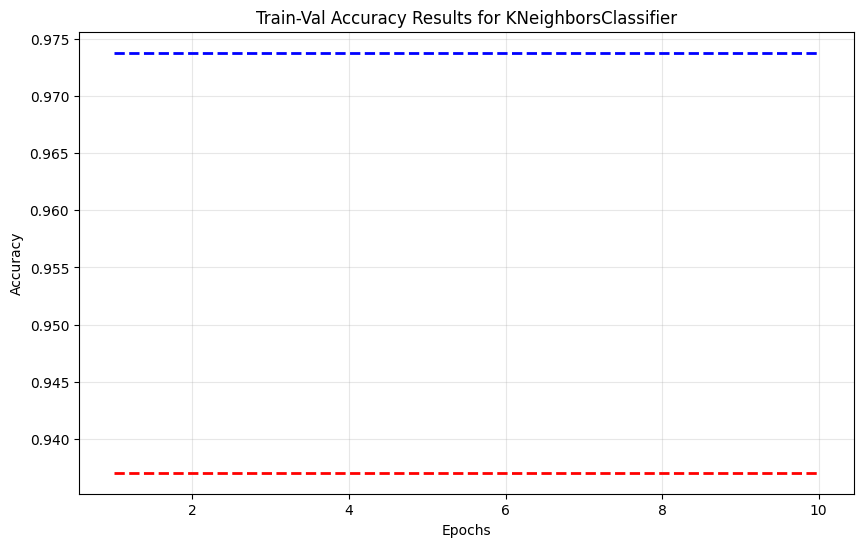

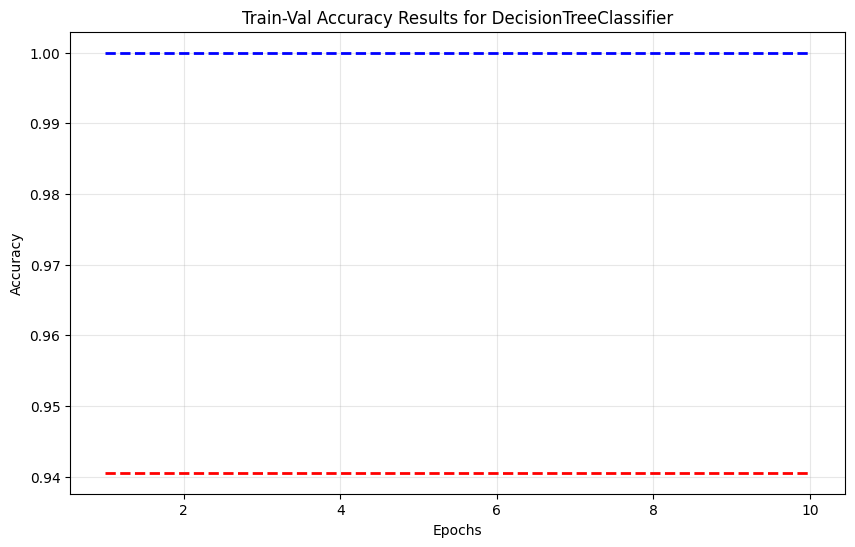

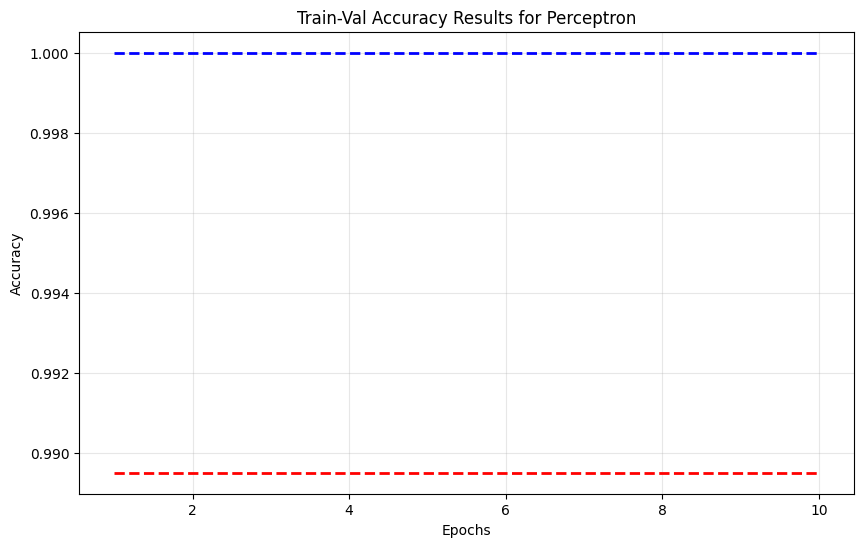

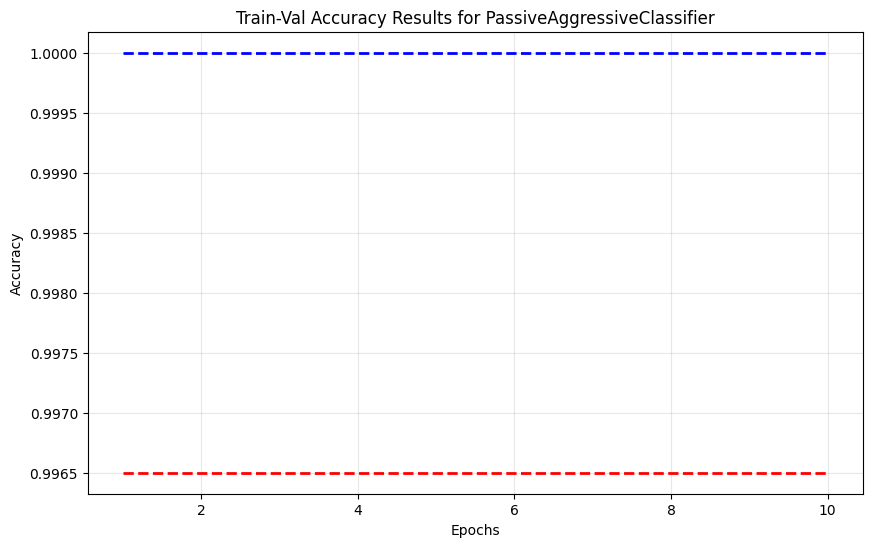

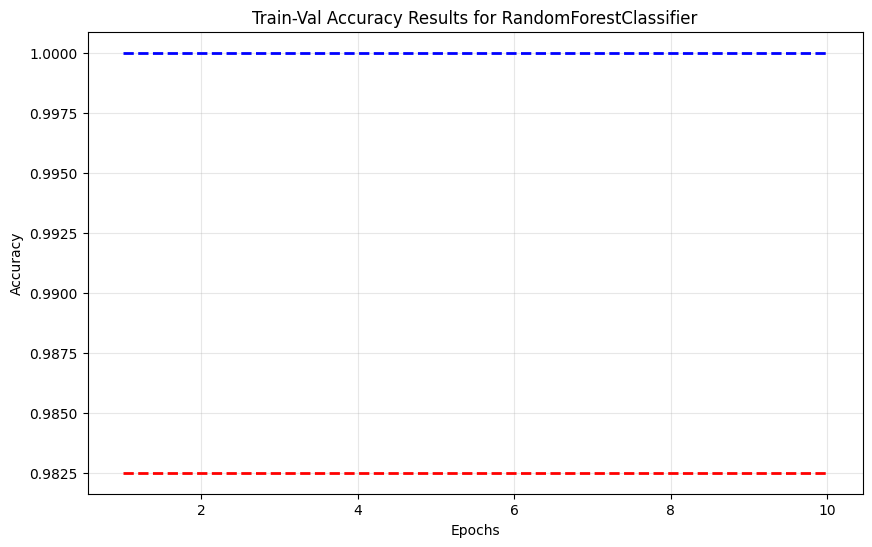

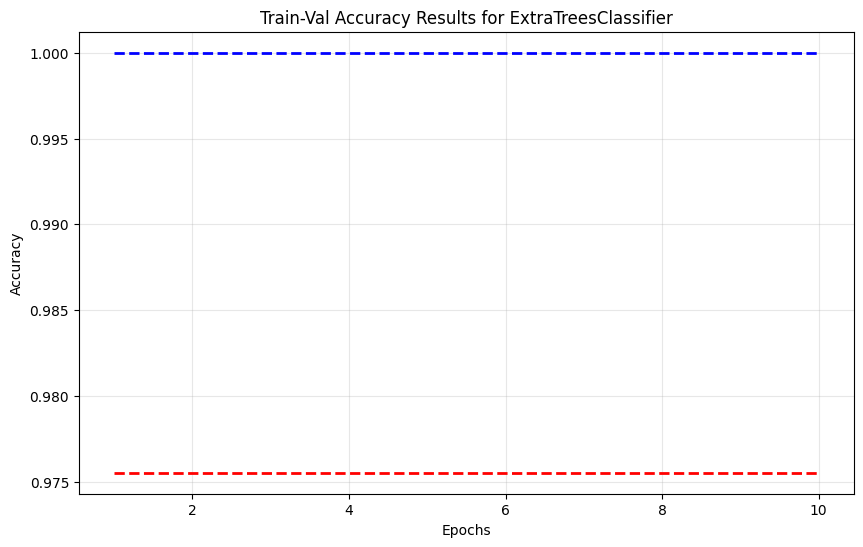

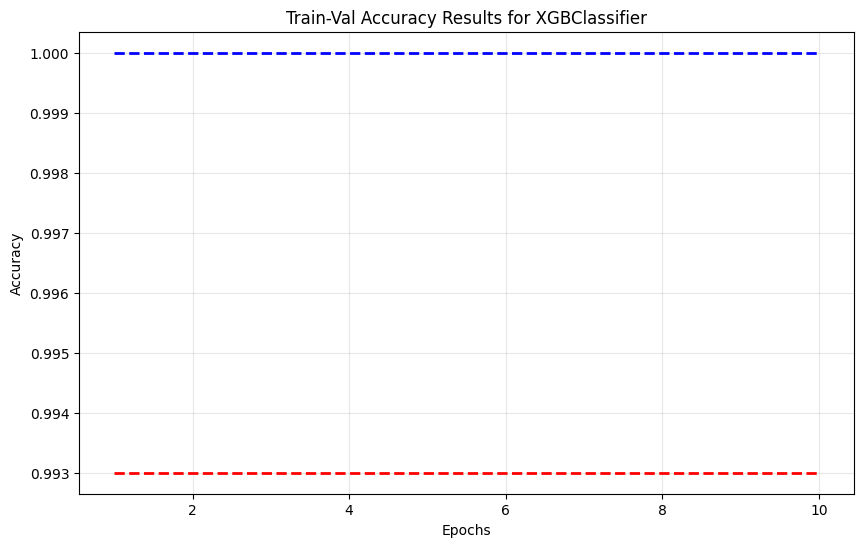

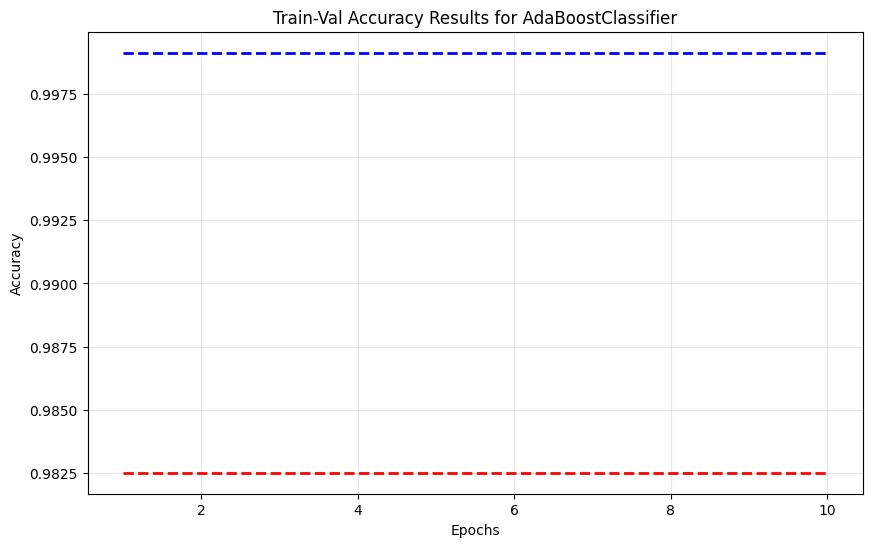

In [12]:
ling_X_lemmatizing_countvec = preprocessing.vectorizing(ling_X_lemmatizing, "countvectorizer")

clsml2 = ClassificationModel2(ling_X_lemmatizing_countvec, ling_y, "spam_assassin_lemmatized_countvec")
clsml2.split()

m_r = clsml2.train_and_evaluate_models(
    valid_size=0.1,
    max_workers=4,
    nomlp=True,
    threading=True,
    save_plot=True
)

metric_results.extend(m_r)

del m_r

del ling_X_lemmatizing_countvec

## Lemmatizing + TF-IDF

Val size:  (286, 12802)
Threading avaiable
Begin KNeighborsClassifier
Skipping epochs training due to longevity.
Begin LinearSVC
Skipping epochs training due to longevity.
Begin MultinomialNB
Skipping epochs training due to longevity.
Begin BernoulliNB
Skipping epochs training due to longevity.
MultinomialNB classification report
range(1, 11)
10
10
LinearSVC classification report
range(1, 11)
10
10
BernoulliNB classification report
range(1, 11)
10
10
Begin RandomForestClassifier
Begin DecisionTreeClassifier
Begin AdaBoostClassifier
Skipping epochs training due to longevity.
RandomForestClassifier classification report
range(1, 11)
10
10
Begin LogisticRegression
DecisionTreeClassifier classification report
range(1, 11)
10
10
Begin SGDClassifier
Begin Perceptron
Skipping epochs training due to longevity.
Perceptron classification report
range(1, 11)
10
10
Begin PassiveAggressiveClassifier
Skipping epochs training due to longevity.
PassiveAggressiveClassifier classification report
range(1

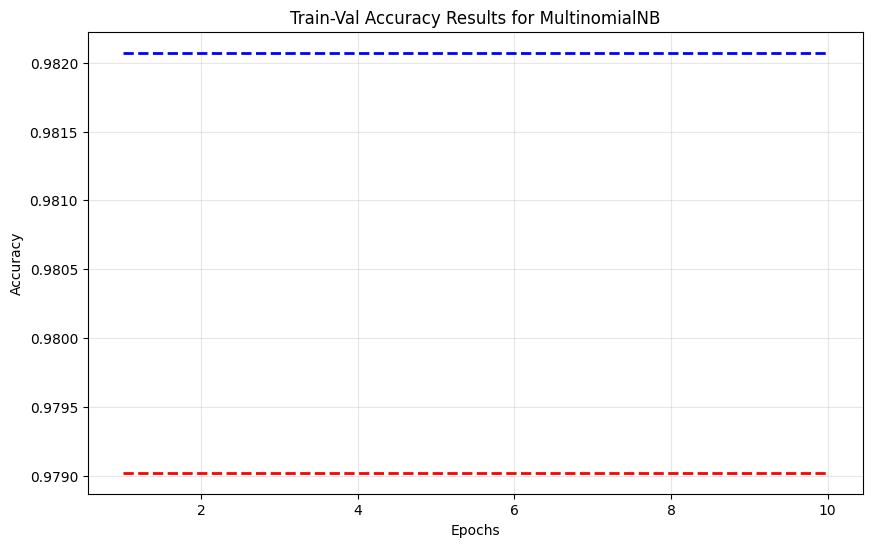

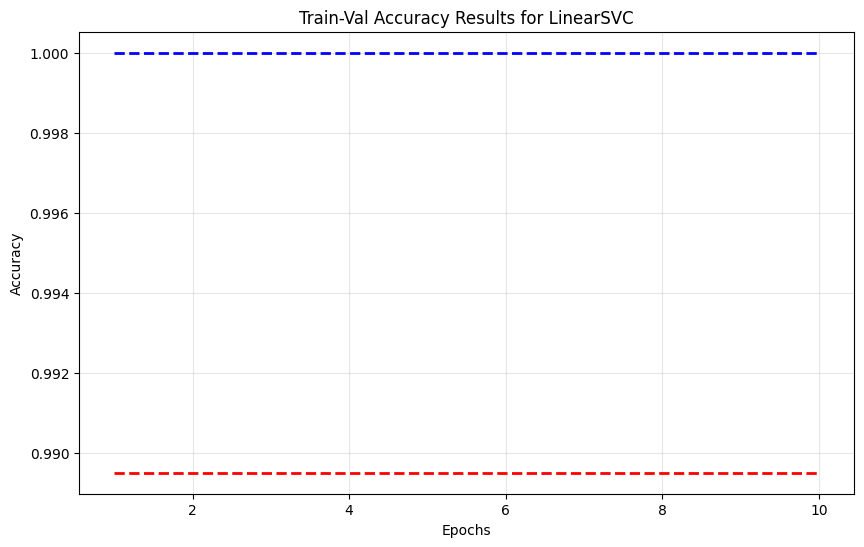

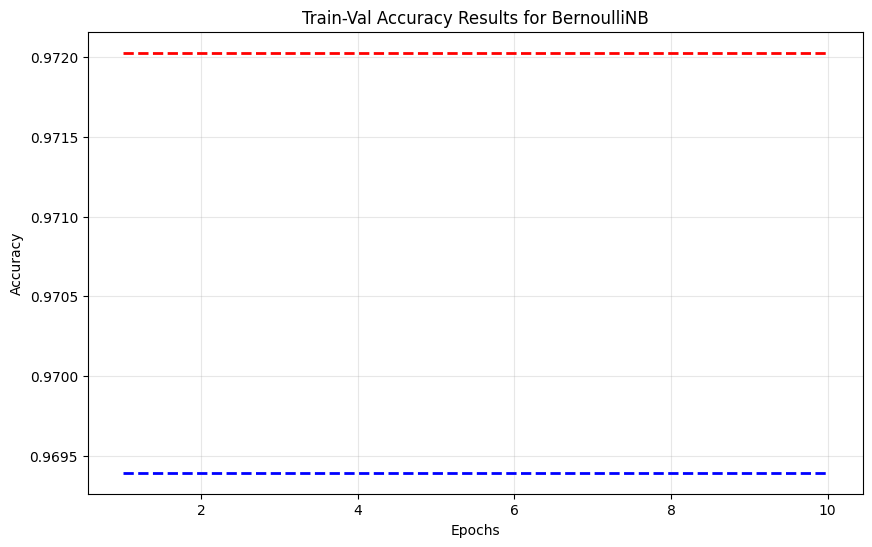

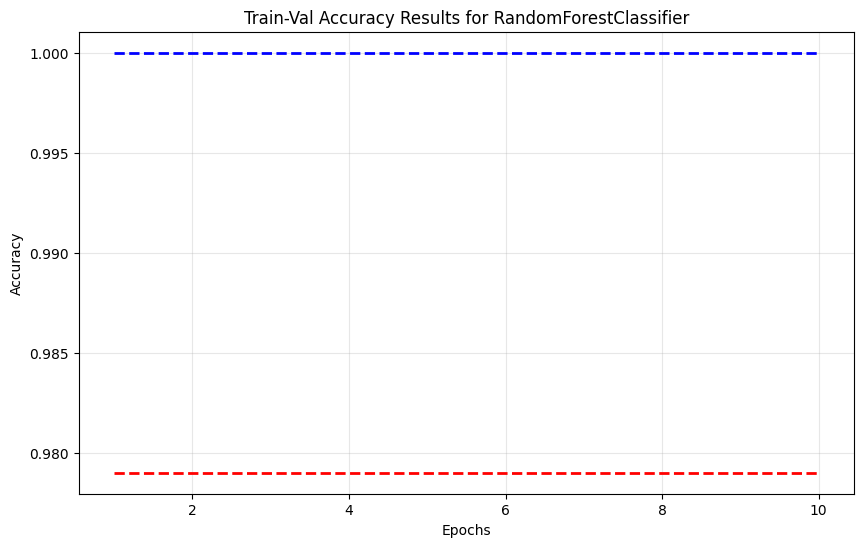

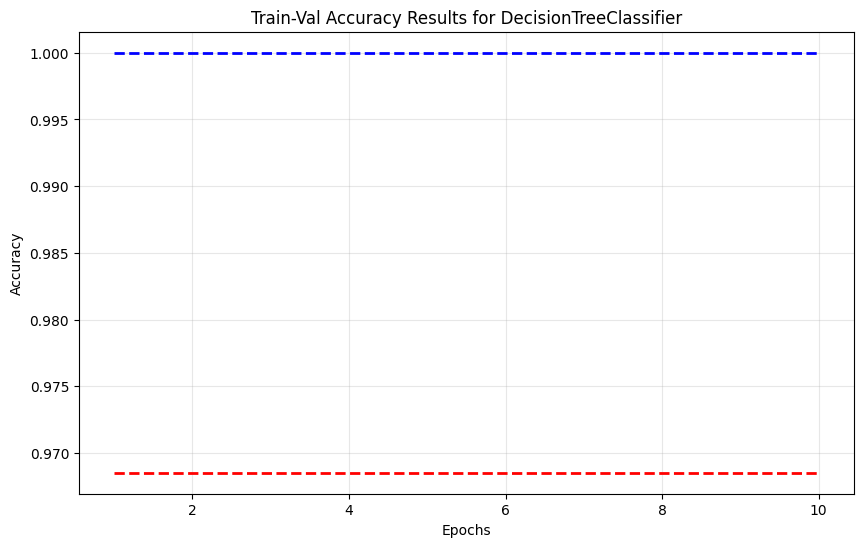

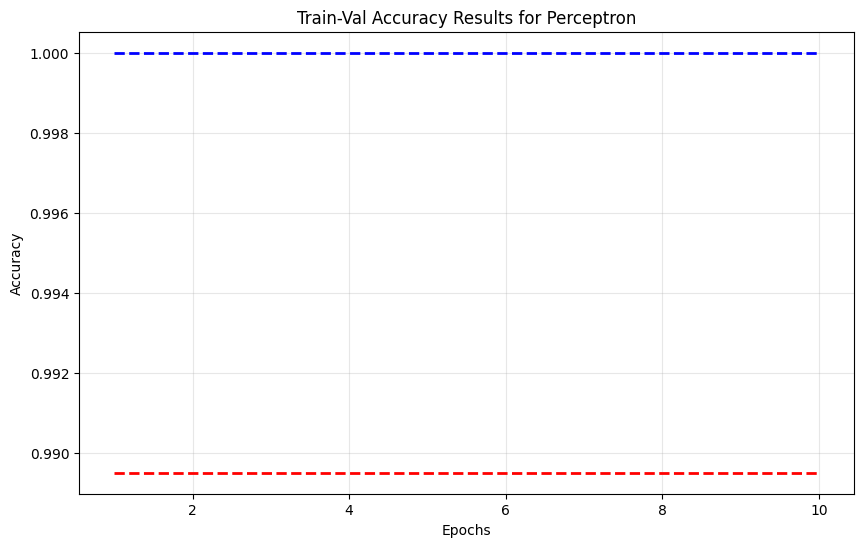

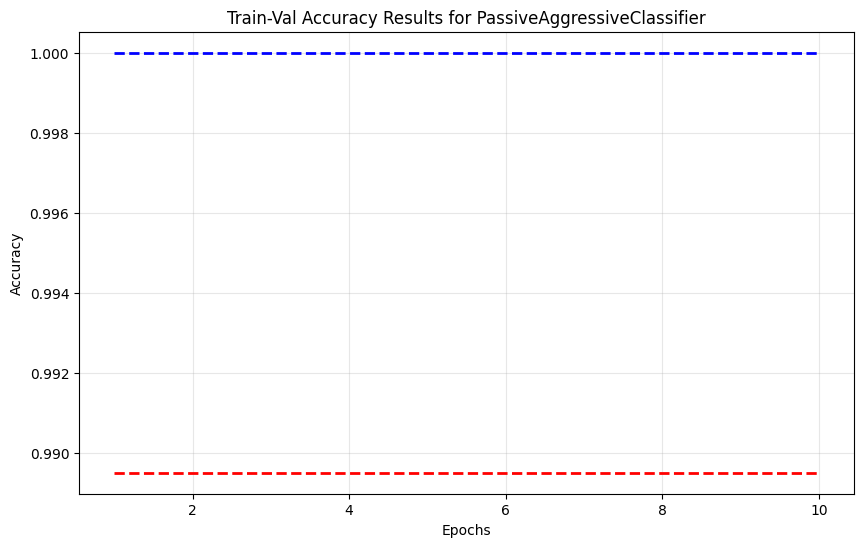

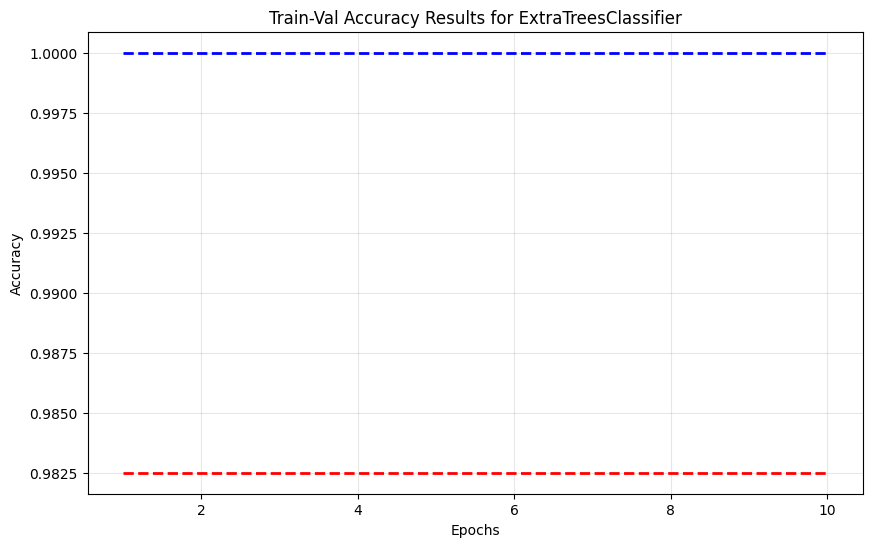

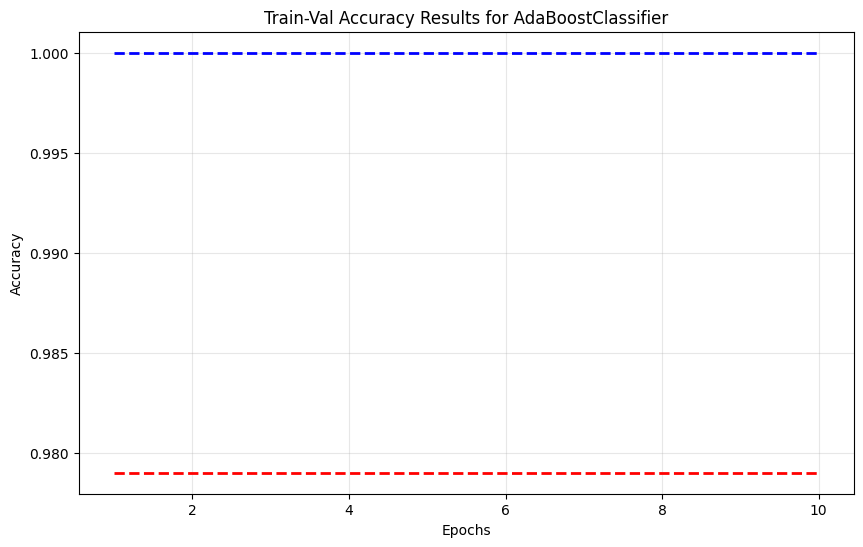

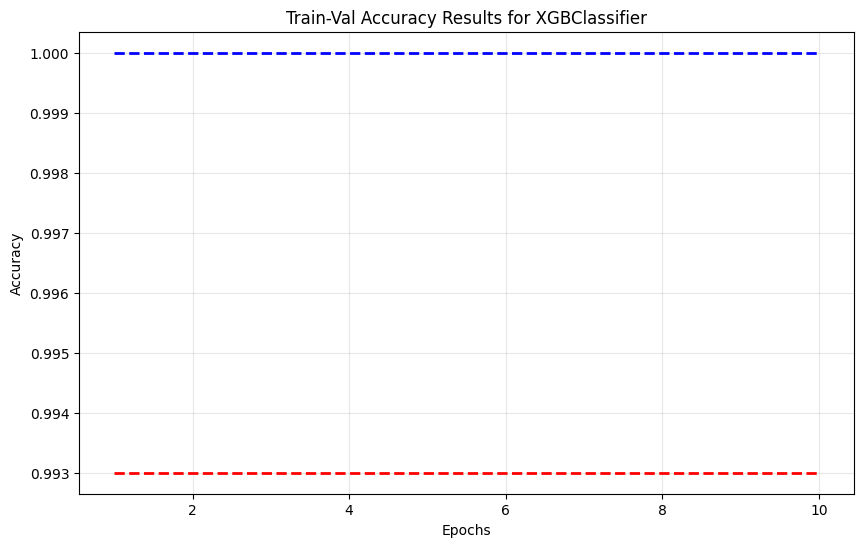

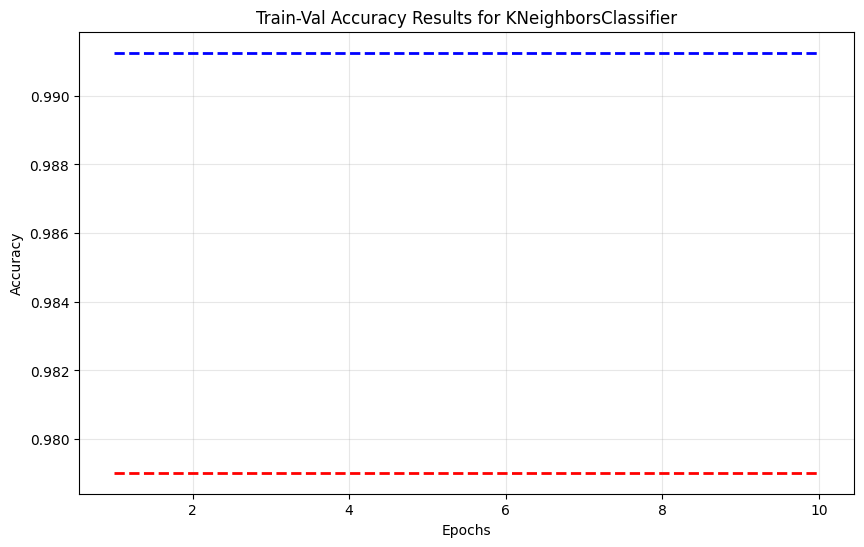

In [13]:
ling_X_lemmatizing_tfidf = preprocessing.vectorizing(ling_X_lemmatizing, "tfidf")

clsml2 = ClassificationModel2(ling_X_lemmatizing_tfidf, ling_y, "spam_assassin_lemmatized_tfidf")
clsml2.split()

m_r = clsml2.train_and_evaluate_models(
    valid_size=0.1,
    max_workers=4,
    nomlp=True,
    threading=True,
    save_plot=True
)

metric_results.extend(m_r)

del ling_X_lemmatizing_tfidf
del ling_X_lemmatizing

In [14]:
def convert(dic):
    dic["confusion_matrix"] = dic["confusion_matrix"].tolist()
    return dic

metric_results = list(map(convert, metric_results))

add_to_json_array("./ling_classification_report.json", metric_results, mode="overwrite")